In [47]:
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Conv1D, Lambda, Dropout, Embedding, Concatenate, Dense
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd
import numpy as np

In [3]:
al = {k: v for v, k in enumerate('abcdefghijklmnopqrstuvwxyz0123456789-_.')}
def vectorize(X):
    return pad_sequences(X.apply(lambda x: [al[i.lower()] for i in x]), value=0, maxlen=75)

# Обучение модели

In [2]:
def create_model():
    def getconvmodel(kernel_size):
        return Sequential([
            Conv1D(filters=256, kernel_size=kernel_size, padding='same', activation='relu', strides=1),
            Lambda(lambda x: K.sum(x, axis=1), output_shape=(256, )),
            Dropout(.5)
        ])
    main_input = Input(shape=(75, ), dtype='int32', name='main_input')
    embedding = Embedding(input_dim=39, output_dim=39, input_length=75)(main_input)
    conv1 = getconvmodel(2)(embedding)
    conv2 = getconvmodel(3)(embedding)
    conv3 = getconvmodel(4)(embedding)
    conv4 = getconvmodel(5)(embedding)
    merged = Concatenate()([conv1, conv2, conv3, conv4])
    middle = Dense(1024, activation='relu')(merged)
    middle = Dropout(.5)(middle)
    middle = Dense(1024, activation='relu')(middle)
    middle = Dropout(.5)(middle)
    output = Dense(1, activation='sigmoid')(middle)
    model = Model(inputs=main_input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
    return model

In [ ]:
df = pd.read_csv('dga_domains_full.csv')
X, y = vectorize(df['domain']), (df['dga'] == 'dga') * 1

In [ ]:
model.fit(X, y, epochs=5)
model.save('./model.h5')

# Тестирование

In [4]:
a = []
for line in open('dga'):
    a.append([line.split()[0].strip(), 1])
for line in open('legit'):
    a.append([line.strip(), 0]) 
    
df = pd.DataFrame(a, columns=['domain', 'label'])
df = df.sample(frac=1).reset_index(drop=True)

X, y = vectorize(df['domain']), df['label']

In [6]:
model = load_model('./model.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 39)       1521        main_input[0][0]                 
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          20224       embedding[0][0]                  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256)          30208       embedding[0][0]                  
_______________________________________________________________________________________

In [7]:
P = model.predict(X)

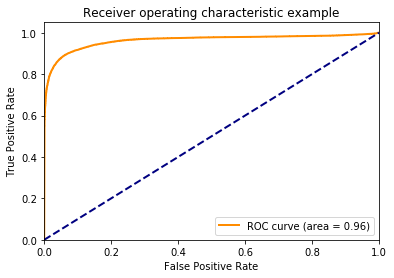

In [8]:
fpr, tpr, _ = roc_curve(y, P)
roc_auc = auc(fpr, tpr)
plt.figure()

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

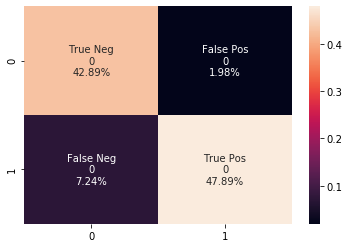

In [49]:
cf = confusion_matrix(y, P.round())
cf_matrix = cf / cf.sum()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='')